# 0.0 IMPORTS


## 0.1 Helper Functions

In [170]:
import pandas            as pd 
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import scipy.stats       as ss
import math
import inflection
import datetime
import sys

from IPython.core.display  import HTML
from IPython.display       import Image
from matplotlib.gridspec   import GridSpec
from tabulate              import tabulate
from scipy                 import stats  
from sklearn.preprocessing import RobustScaler, MinMaxScaler




## 0.1.1 Config Fuctions Jupyter Notebook 

In [141]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 6]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r , k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return  np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1) ) ) 

# 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv',low_memory=False)
df_store_raw = pd.read_csv('data/store.csv',low_memory=False)

#Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Step 1 -  DATA DESCRIPTION 

In [4]:
df1 = df_raw.copy()

In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x ) 

cols_new = list( map( snakecase, cols_old) ) 

#Rename
df1.columns = cols_new


## 1.2 Data Dimensions

In [7]:
print( 'Number of Rows: {}'.format(df1.shape[0] ) ) 
print( 'Number of Cols: {}'.format(df1.shape[1] ) ) 

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types 

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check N/A

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout N/A

In [10]:
df1['competition_distance'].max()

np.float64(75860.0)

In [11]:
# competition_distance 

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x ) 

# competition_open_since_month

df1[ 'competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year 

df1[ 'competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
                            
# promo2_since_week

df1[ 'promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year   

df1[ 'promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval  

month_map = { 1: 'Jan', 2: 'Fev', 3:'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'] = df1['promo_interval'].fillna(0)


df1['month_map'] = df1['date'].dt.month.map(month_map)

df1[ 'is_promo' ] = df1[[ 'promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval' ] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' )else 0, axis=1)



In [12]:
df1.sample(5).T

,451799,11534,928747,169834,346279
store,1010,385,738,355,601
day_of_week,5,2,4,7,5
date,2014-05-23 00:00:00,2015-07-21 00:00:00,2013-03-21 00:00:00,2015-03-01 00:00:00,2014-09-05 00:00:00
sales,10009,4698,8457,0,5384
customers,902,477,710,0,412
open,1,1,1,0,1
promo,1,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,1
store_type,d,d,d,a,d


In [13]:
df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change types

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] ) 
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ) 

In [16]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
739450,991,6,6001,578,1,0,0,1010.0,9,2013,0,36,2013,0
469737,1108,3,6651,687,1,1,0,540.0,4,2004,0,19,2014,0


In [17]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
947872,0,a,a,"Jan,Apr,Jul,Oct",Mar
924519,0,a,a,"Jan,Apr,Jul,Oct",Mar


### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispesion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
display(m)


,index,0,0,0,0,0,0,0,0
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/3866287872.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1 ['sales'] )


<Axes: xlabel='sales', ylabel='Density'>

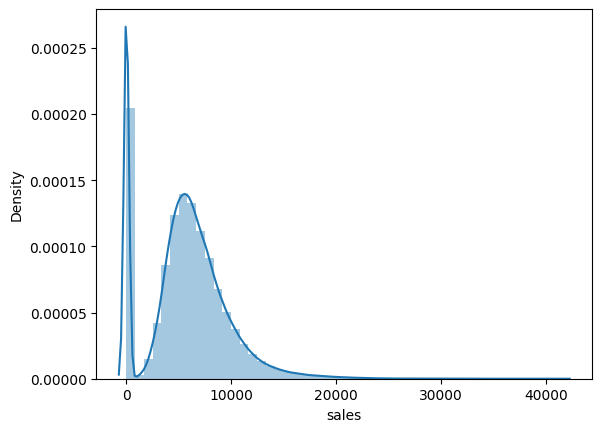

In [19]:
sns.distplot( df1 ['sales'] )

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Figure size 1200x500 with 0 Axes>

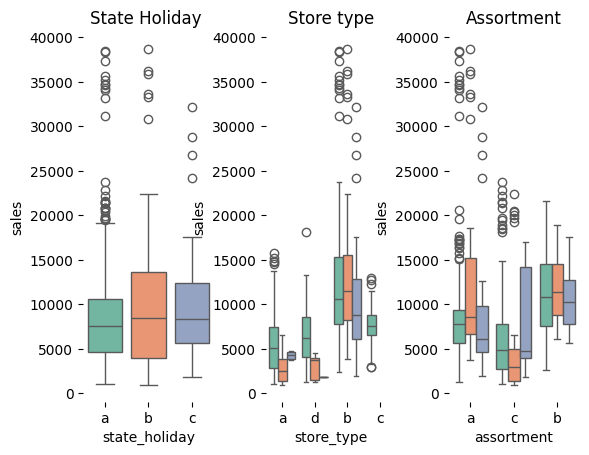

<Figure size 1200x500 with 0 Axes>

In [21]:
aux1 = df1 [ ( df1[ 'state_holiday'] != '0' ) & ( df1['sales'] > 0) ]

plt.subplot( 1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday', palette='Set2', legend=False)
plt.title('State Holiday ')
sns.despine(left=True, bottom=True)

plt.subplot( 1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1, hue='state_holiday', palette='Set2', legend=False)
plt.title('Store type')
sns.despine(left=True, bottom=True)

plt.subplot( 1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1, hue='state_holiday', palette='Set2', legend=False)
plt.title('Assortment')
sns.despine(left=True, bottom=True)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.figure(figsize=(12, 5))



# 2.0 Step 2 - FEATURE ENGINEERING 

In [22]:
df2 = df1.copy()

## 2.1 Mind Map hight Hypotheses 

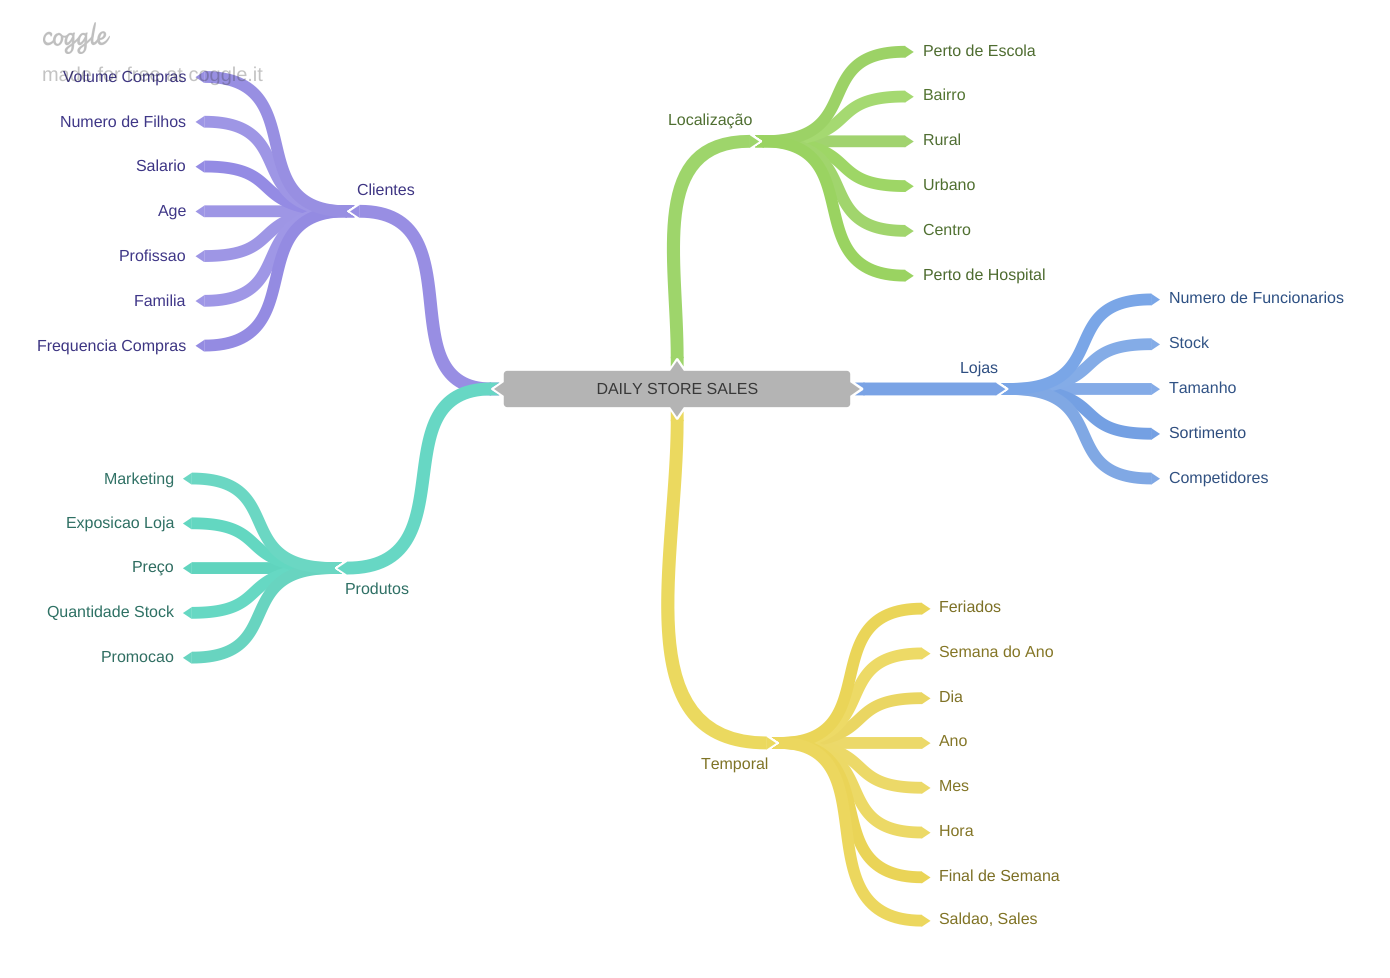

In [23]:
Image('img/MindMapHypothesis.png', width=600)


## 2.2 Creation of Hypotheses 

### 2.2.1 Shop Hypotheses 

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with greater stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors for longer should sell more.

### 2.2.2 Products Hypotheses 


**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with greater product display should have more.

**3.** Stores with lower priced products should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with active promotions for longer should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 2.2.3 Time Hypotheses 

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

### 2.2.4 Lista final de Hipoteses

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with competitors for longer should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.3. Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month 
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
# Atualizando o código para usar a nova abordagem
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week 
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since 
df2['competition_since']= df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) /30 ).apply(lambda x: x.days ).astype( int ) 

# promo since 
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str ) 
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ) .apply(lambda x: x.days ).astype( int ) 

# assortiment 
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday 
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x== 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0  STEP 3 - VARIABLE FILTERING

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Row Filtering

In [28]:
df3 = df3[(df3['open'] !=0) & ( df3['sales'] > 0 ) ]

In [29]:
print(df3.columns.tolist())

['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year', 'month', 'day', 'week_of_year', 'year_week', 'competition_since', 'competition_time_month', 'promo_since', 'promo_time_week']


## 3.1 Column Filt

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1 ) 

# 4.0  STEP 4 - EXPLORATORY DATA ANALYSIS

In [31]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

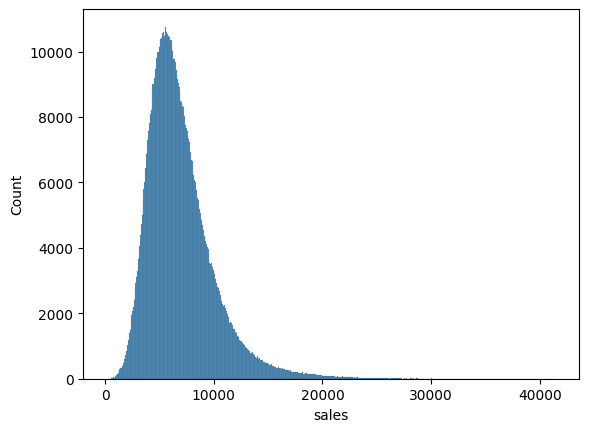

In [32]:
sns.histplot(data=df4, x='sales', kde=False);

### 4.1.2 Numerical Variable

<Figure size 2000x1500 with 0 Axes>

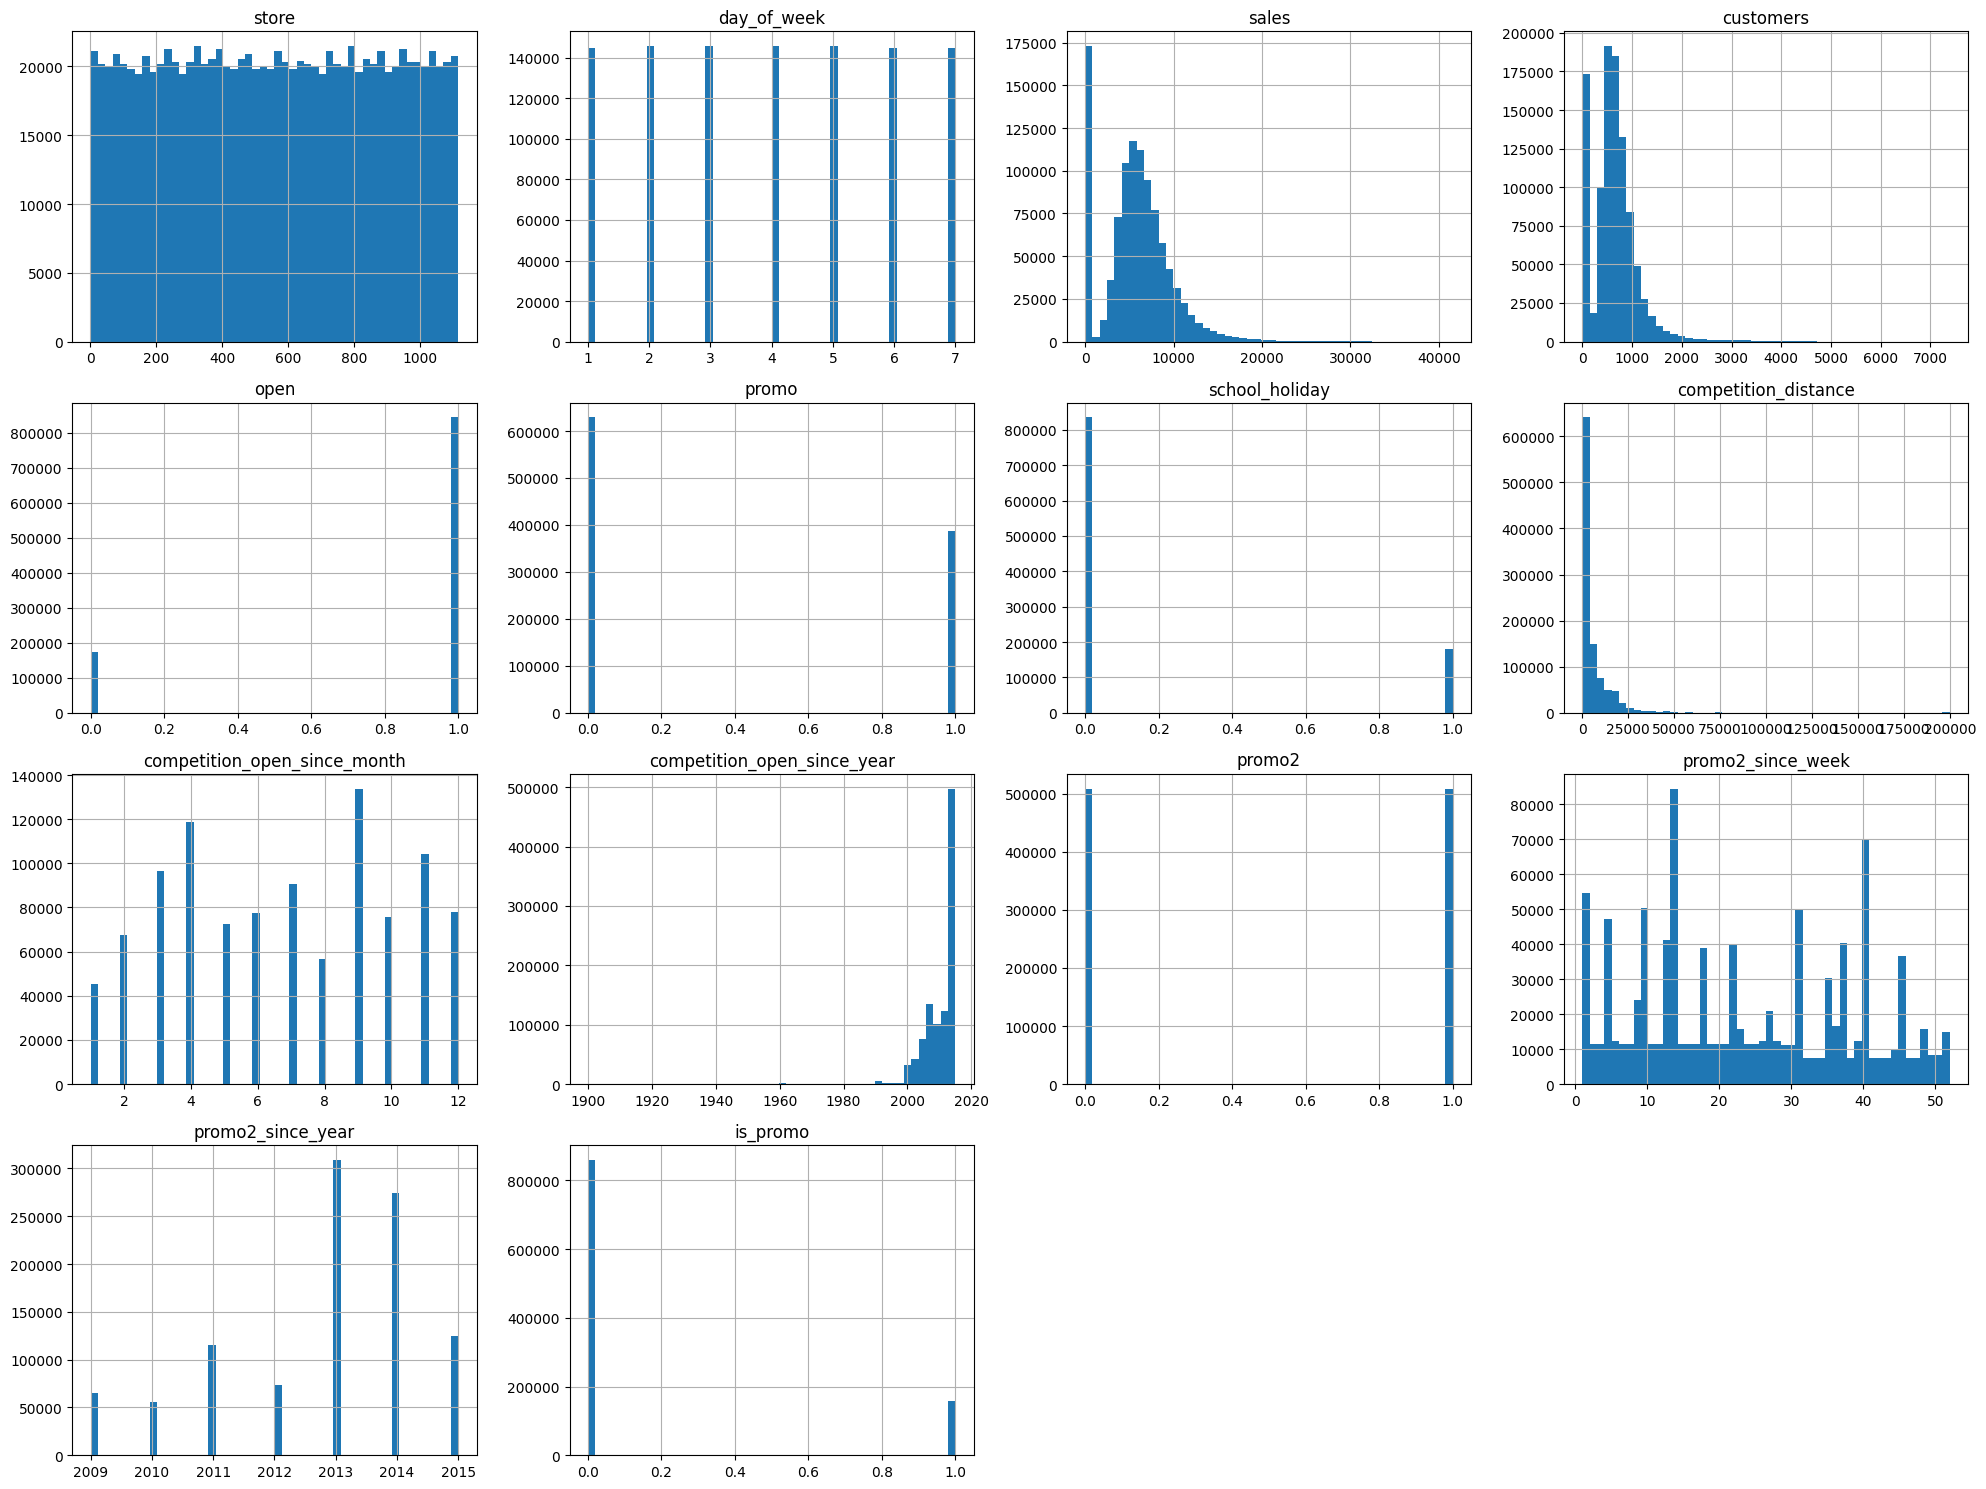

In [33]:
plt.figure(figsize=(20, 15))  # Ajuste o tamanho da figura
num_attributes.hist(bins=50, figsize=(20, 15));
plt.tight_layout()  # Ajuste o layout dos subplots para evitar sobreposição
plt.show()

### 4.1.3 Categorical Variable 

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

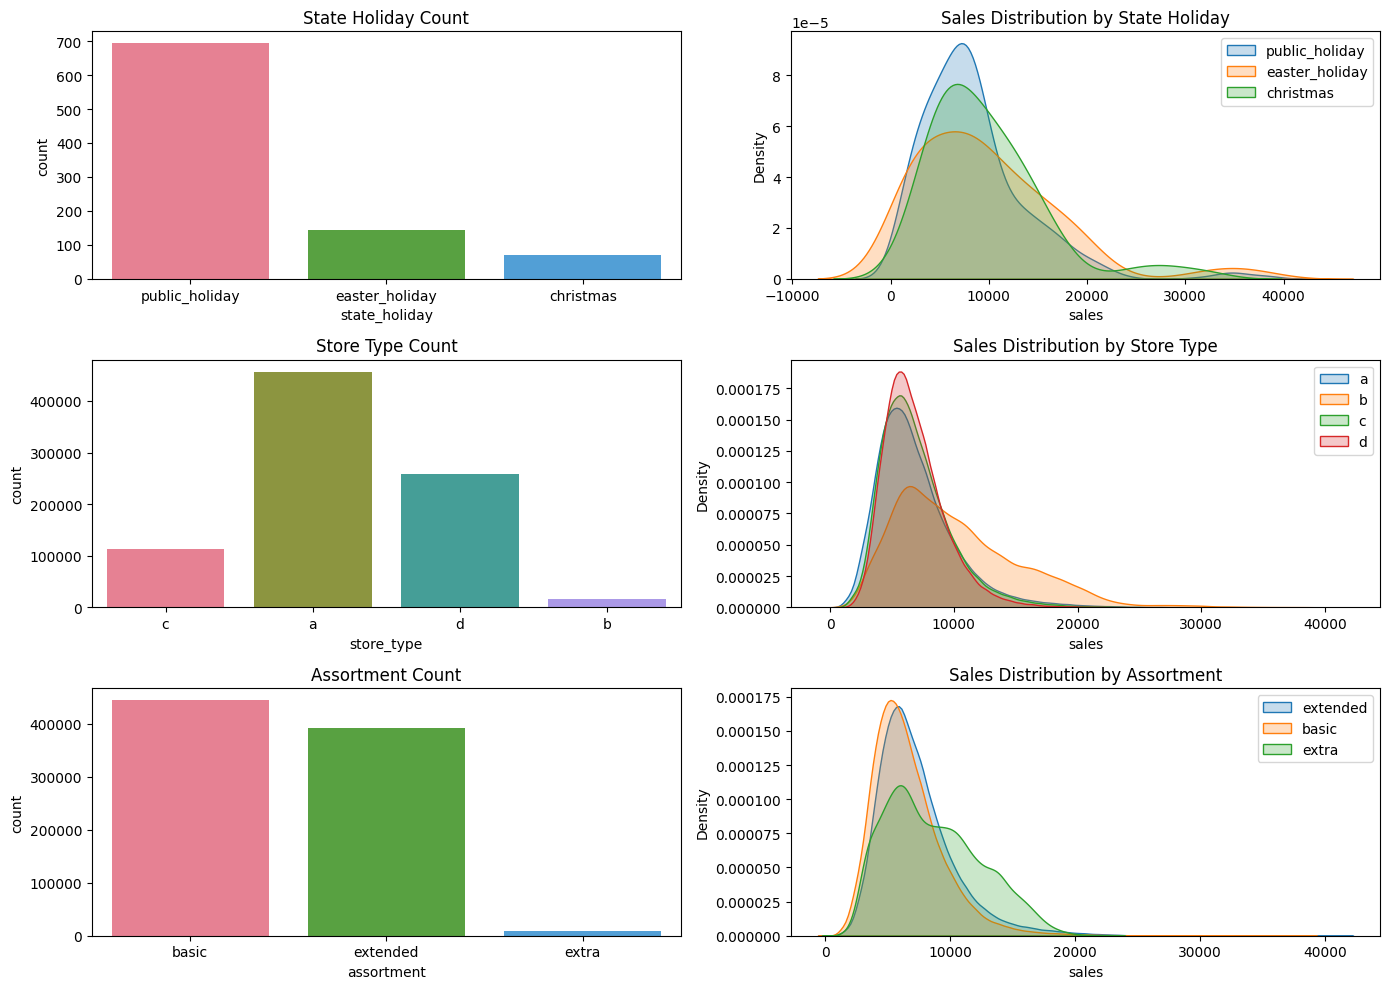

In [35]:
# Configuração do tamanho da figura
plt.figure(figsize=(14, 10))

# Gráfico 1: state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a, hue='state_holiday', palette="husl", legend=False)
plt.title('State Holiday Count')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.title('Sales Distribution by State Holiday')
plt.legend()

# Gráfico 2: store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4, hue='store_type', palette="husl", legend=False)
plt.title('Store Type Count')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.title('Sales Distribution by Store Type')
plt.legend()

# Gráfico 3: assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4, hue='assortment', palette="husl", legend=False)
plt.title('Assortment Count')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.title('Sales Distribution by Assortment')
plt.legend()

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()


## 4.2 Bivariate Analysis

### **H1.** Stores with a larger assortment should sell more.
**False**: Stores with a larger ASSORTMENT sell LESS.


<Axes: xlabel='year_week'>

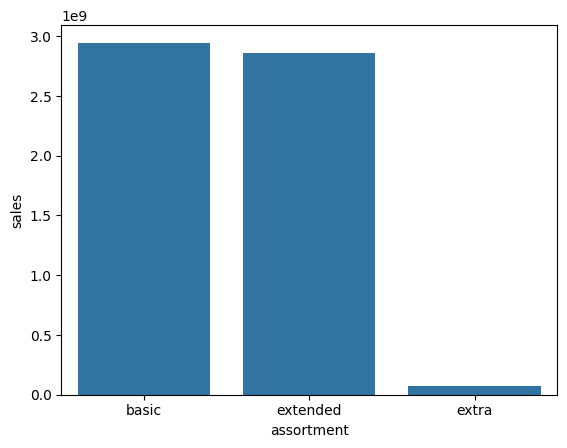

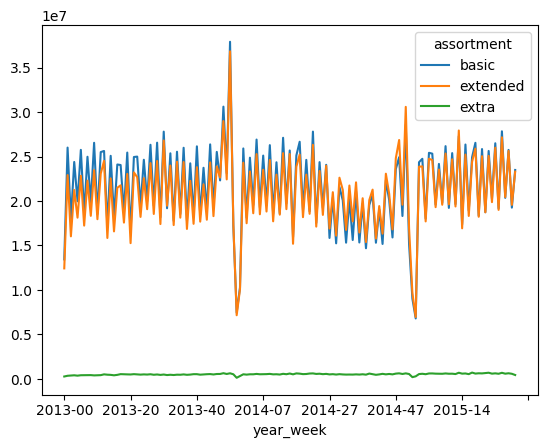

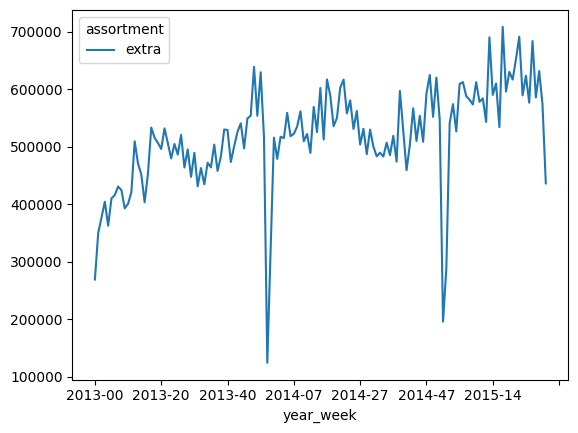

In [36]:
aux1 = df4 [[ 'assortment' , 'sales' ]].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment' , y= 'sales', data=aux1, );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra' ]
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()



### **H2.** Stores with closer competitors should sell less.
**False**: Stores with closer COMPETITORS SELL MORE.

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/4212447989.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


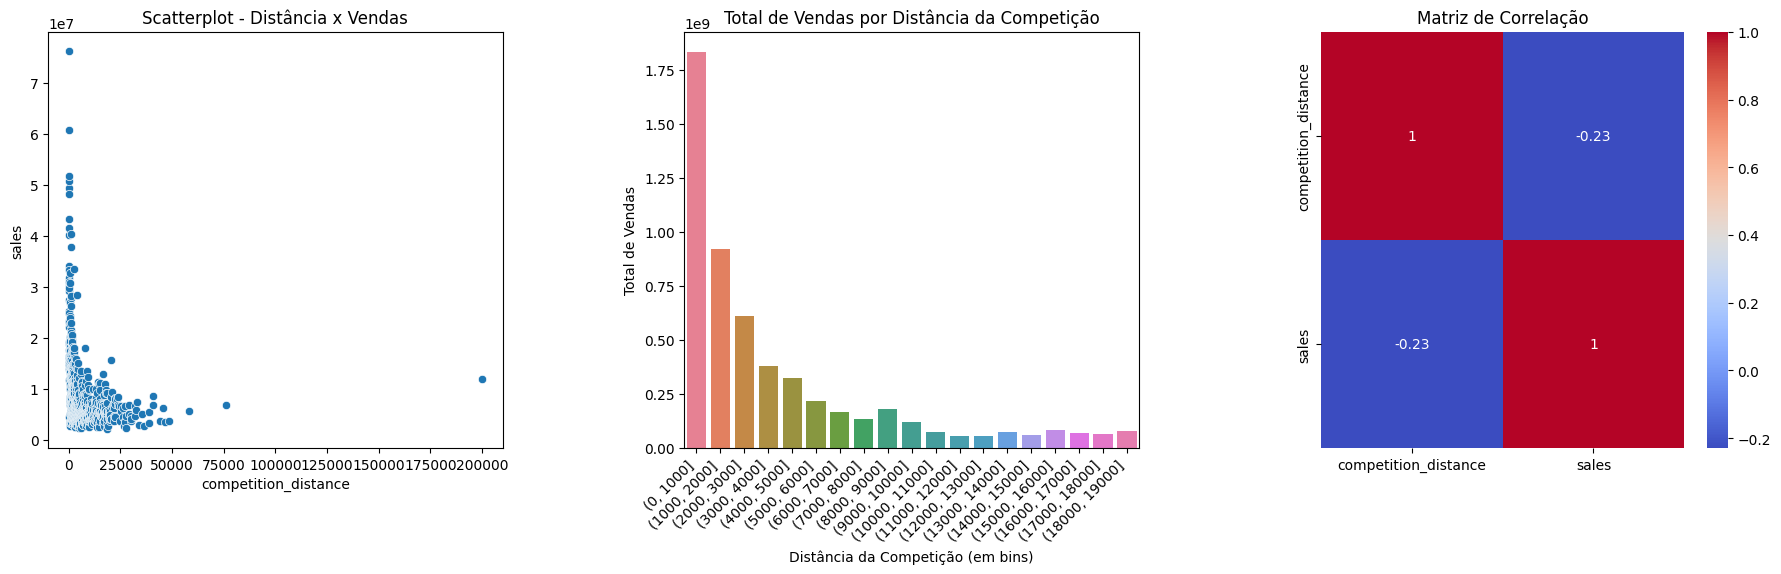

In [37]:
# Gerando os dados agrupados
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Criação da figura e subplots (1 linha, 3 colunas)
plt.figure(figsize=(18, 6))  # Definindo uma figura maior para acomodar os 3 gráficos

# Subplot 1: Scatterplot
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title('Scatterplot - Distância x Vendas')

# Subplot 2: Gráfico de Barras com Bins
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))  # Definindo os bins para a distância

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

# Agrupando por bins
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

# Plotando o gráfico de barras
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, hue='competition_distance_binned', palette='husl', legend=False)
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x
plt.title('Total de Vendas por Distância da Competição')
plt.xlabel('Distância da Competição (em bins)')
plt.ylabel('Total de Vendas')

# Subplot 3: Heatmap de correlação (Removendo a coluna categórica)
plt.subplot(1, 3, 3)
# Removendo a coluna categórica para calcular a correlação corretamente
aux1_numeric = aux1.drop(columns=['competition_distance_binned'])
sns.heatmap(aux1_numeric.corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')

# Ajuste de layout para evitar sobreposição
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  # Ajuste a distância horizontal entre os subplots

plt.show()


### **H3.** Stores with competitors for longer should sell more.
**False** Sotre with COMPETITORS that have been around for longer sell less. 

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/2011994374.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='competition_time_month', y='sales', data=aux2, palette='tab10')


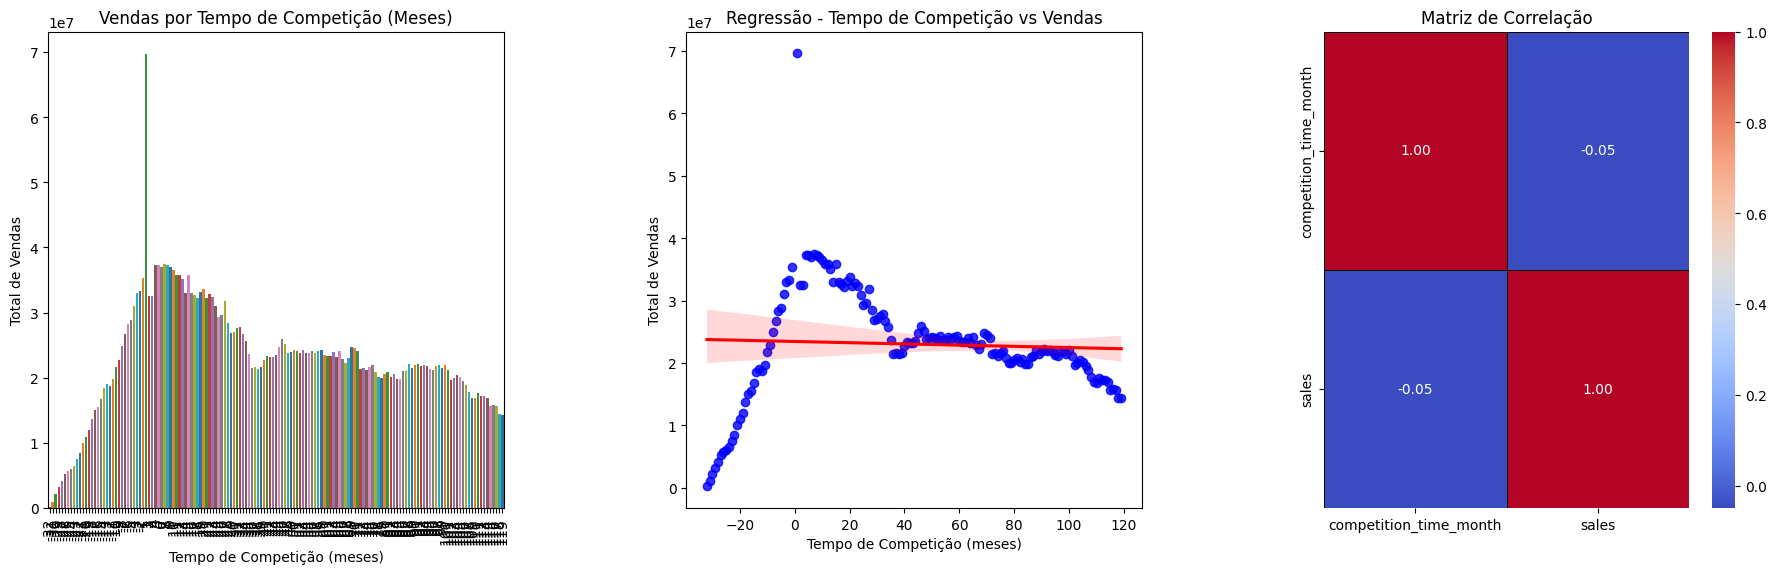

In [44]:
# Subplot 1: Gráfico de Barras
plt.figure(figsize=(18, 6))  # Definindo o tamanho da figura para acomodar os subplots

# Subplot 1: Gráfico de Barras
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# Corrigindo o filtro para competition_time_month
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

# Usando uma paleta de cores distintas para o gráfico de barras
sns.barplot(x='competition_time_month', y='sales', data=aux2, palette='tab10')
plt.xticks(rotation=90)  # Rotaciona os rótulos do eixo X para evitar sobreposição
plt.title('Vendas por Tempo de Competição (Meses)')
plt.xlabel('Tempo de Competição (meses)')
plt.ylabel('Total de Vendas')

# Subplot 2: Gráfico de Regressão
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Regressão - Tempo de Competição vs Vendas')
plt.xlabel('Tempo de Competição (meses)')
plt.ylabel('Total de Vendas')

# Subplot 3: Heatmap de Correlação
plt.subplot(1, 3, 3)
# Se precisar de uma matriz de correlação com mais dados, ajuste aqui
sns.heatmap(aux2.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Matriz de Correlação')

# Ajuste de layout para evitar sobreposição
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  # Ajuste da distância entre os gráficos
plt.show()



### **H4.** Stores with active promotions for longer should sell more.
**FALSE** Store with promotions active for longer period sell less affter a certain period of promotion

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/2286140401.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='promo_time_week', y='sales', data=aux2, palette='tab10')
/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/2286140401.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='promo_time_week', y='sales', data=aux3, palette='tab10')


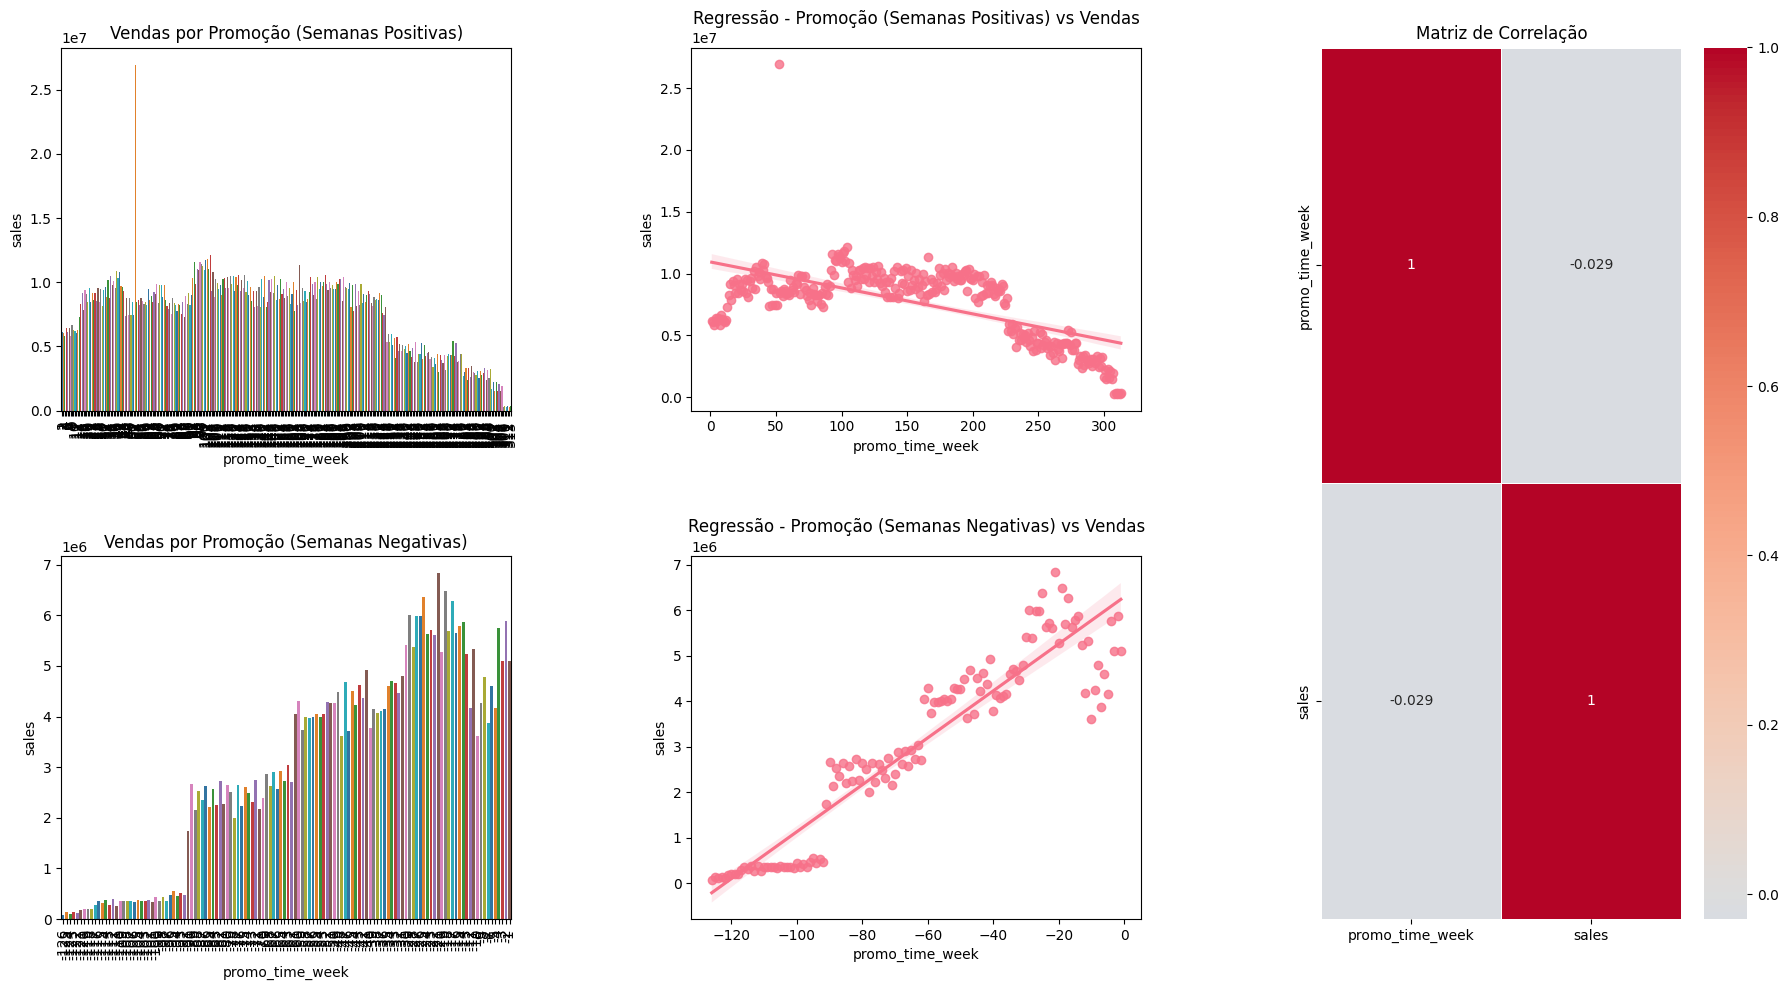

In [61]:


# Gerando os dados agrupados
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Definindo o tamanho da figura e a configuração do GridSpec
plt.figure(figsize=(18, 10))  # Aumenta o tamanho da figura para melhorar a visualização
grid = GridSpec(2, 3)

# Subplot 1: Gráfico de Barras (promo_time_week > 0)
plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # Filtro: promo_time_week > 0
sns.barplot(x='promo_time_week', y='sales', data=aux2, palette='tab10')
plt.xticks(rotation=90)
plt.title('Vendas por Promoção (Semanas Positivas)')

# Subplot 2: Regressão (promo_time_week > 0)
plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Regressão - Promoção (Semanas Positivas) vs Vendas')

# Subplot 3: Gráfico de Barras (promo_time_week < 0)
plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # Filtro: promo_time_week < 0
sns.barplot(x='promo_time_week', y='sales', data=aux3, palette='tab10')
plt.xticks(rotation=90)
plt.title('Vendas por Promoção (Semanas Negativas)')

# Subplot 4: Regressão (promo_time_week < 0)
plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Regressão - Promoção (Semanas Negativas) vs Vendas')

# Subplot 5: Heatmap de Correlação (colunas numéricas)
plt.subplot(grid[:, 2])

# Gerando a matriz de correlação para promo_time_week e sales
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matriz de Correlação')

# Ajuste final no layout para evitar sobreposição
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Ajuste de espaço entre os gráficos

# Exibir os gráficos
plt.show()


### <s> **H5.** Stores with more promotion days should sell more.</s>

### **H6.** Stores with more consecutive promotions should sell more.
**FALSE** Stores with more consecutive promotions sell less.

In [62]:
df4[ [ 'promo', 'promo2', 'sales']]. groupby( [ 'promo', 'promo2' ] ) .sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


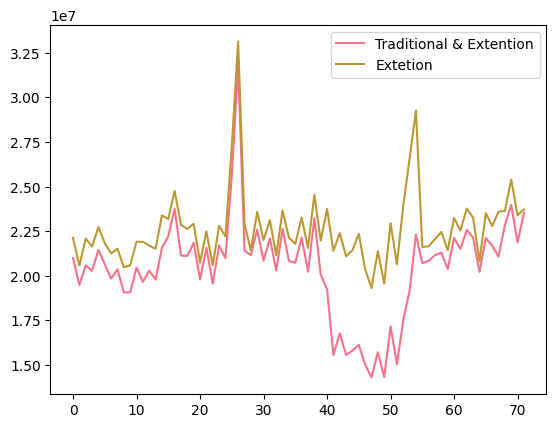

In [66]:
aux1 = df4[ ( df4['promo'] == 1 ) & ( df4[ 'promo2' ] == 1 )][[ 'year_week' , 'sales']].groupby( 'year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[ ( df4['promo'] == 1 ) & ( df4[ 'promo2' ] == 0 )][[ 'year_week' , 'sales']].groupby( 'year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Traditional & Extention' , 'Extetion']);


### **H7.** Stores open during the Christmas holiday should sell more.
**FALSE** Stores open during the Christmas holidays sell less 

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/2206941171.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state_holiday', y='sales', data=aux1, palette='husl')  # Using 'husl' color palette for more color variation


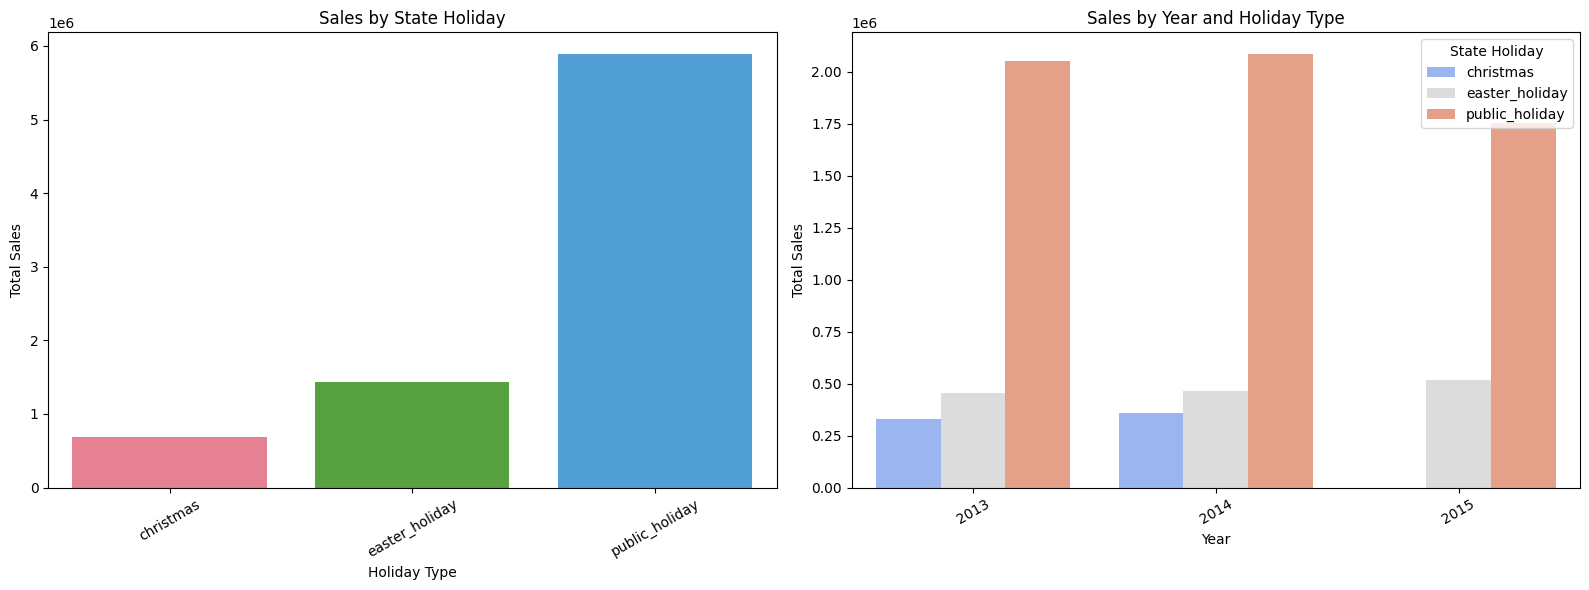

In [84]:
# Filtering the data
aux = df4[df4['state_holiday'] != 'regular_day']

# Defining the figure size for better visualization
plt.figure(figsize=(16, 6))

# Subplot 1: Bar Plot (Sum of Sales by State Holiday)
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, palette='husl')  # Using 'husl' color palette for more color variation
plt.title('Sales by State Holiday')
plt.xlabel('Holiday Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=30)  # Rotating X-axis labels to avoid overlap

# Subplot 2: Bar Plot (Sales by Year and State Holiday)
plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2, palette='coolwarm')  # 'coolwarm' palette for more contrast
plt.title('Sales by Year and Holiday Type')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='State Holiday')  # Legend title for clarity
plt.xticks(rotation=30)  # Rotating X-axis labels for readability

# Adjusting the layout to avoid overlap
plt.tight_layout()
plt.show()




### **H8.** Stores should sell more over the years.
**False** Stores sell less over the years.

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/3103401530.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='sales', data=aux1, palette='coolwarm')  # 'coolwarm' color palette for contrast


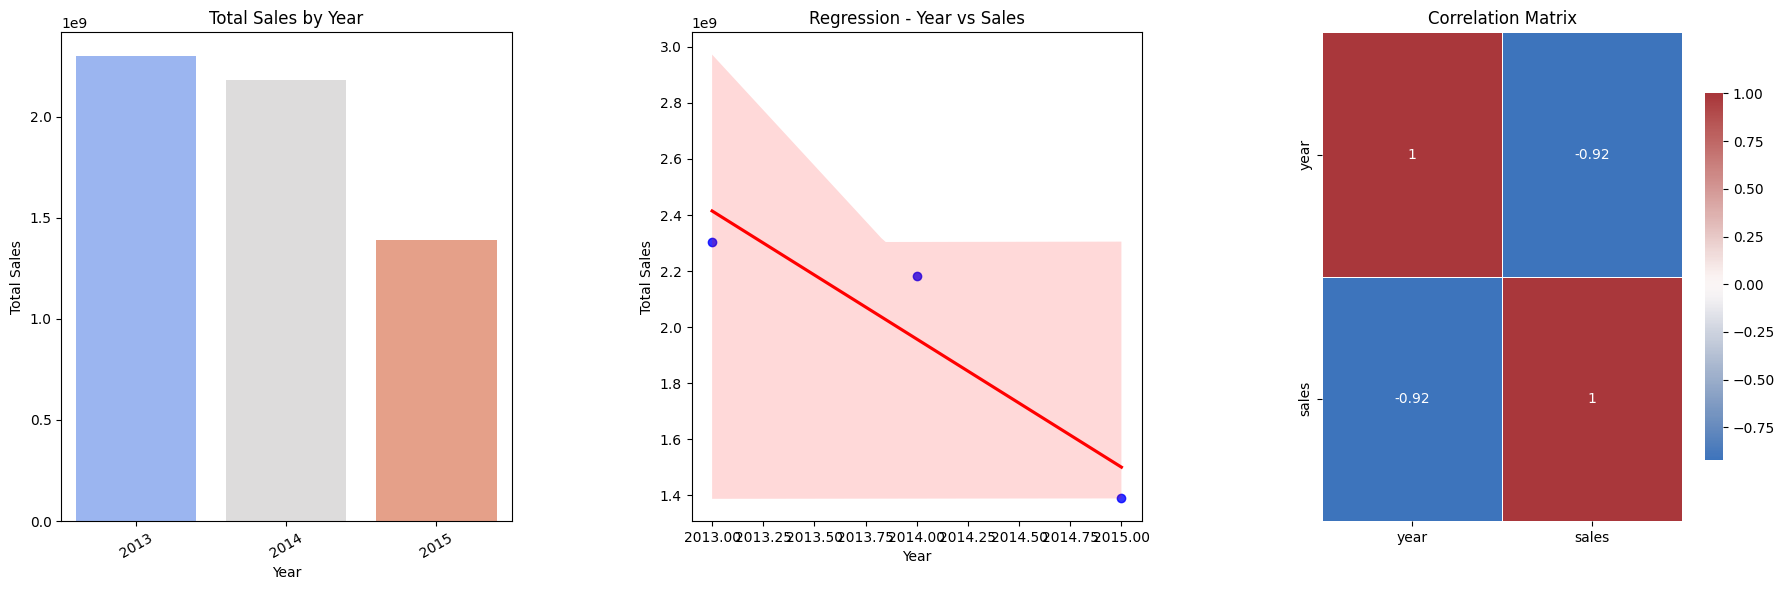

In [83]:
# Generating grouped data by year
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Defining the figure size to better accommodate the plots
plt.figure(figsize=(18, 6))

# Subplot 1: Bar Plot (Total Sales by Year)
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1, palette='coolwarm')  # 'coolwarm' color palette for contrast
plt.title('Total Sales by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=30)  # Rotate X-axis labels for readability

# Subplot 2: Regression Plot (Year vs Sales)
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})  # Custom color settings
plt.title('Regression - Year vs Sales')
plt.xlabel('Year')
plt.ylabel('Total Sales')

# Subplot 3: Correlation Heatmap (Between Year and Sales)
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='vlag', center=0, linewidths=0.5, cbar_kws={"shrink": 0.75})  # 'vlag' palette for smooth gradient
plt.title('Correlation Matrix')

# Adjusting the layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  # Adjust space between the plots

# Display the plots
plt.show()



### **H9.** Stores should sell more in the second half of the year.
**FALSE** Store sell less in the second half of the year

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/2614030945.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='sales', data=aux1, palette='husl')  # 'husl' palette for more varied colors


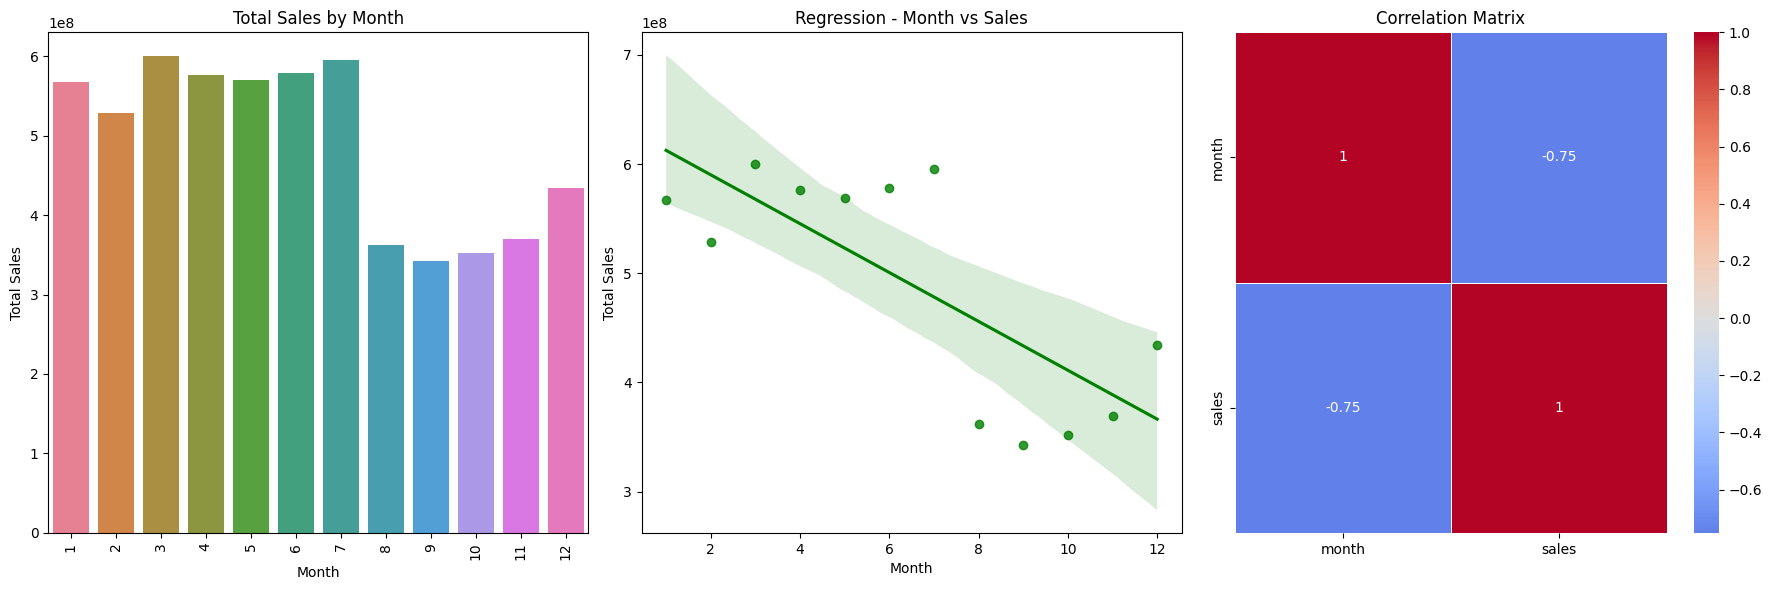

In [82]:
# Grouping the data by month and summing sales
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Defining the figure size
plt.figure(figsize=(18, 6))

# Subplot 1: Colored Bar Plot
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1, palette='husl')  # 'husl' palette for more varied colors
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)  # Rotate X-axis labels for better readability

# Subplot 2: Regression Plot
plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1, color='green')  # Custom color for regression plot
plt.title('Regression - Month vs Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')

# Subplot 3: Correlation Heatmap
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', center=0, linewidths=0.5)  # Colored heatmap with 'coolwarm'
plt.title('Correlation Matrix')

# Adjusting layout to avoid overlap
plt.tight_layout()
plt.show()



### **H10.** Stores should sell more after the 10th of each month.
**TRUE** Stores sell more after the 10th of each month.

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/1374119306.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day', y='sales', data=aux1, palette='husl')  # 'husl' palette for more varied colors
/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/1374119306.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='before_after', y='sales', data=aux2, palette='husl')


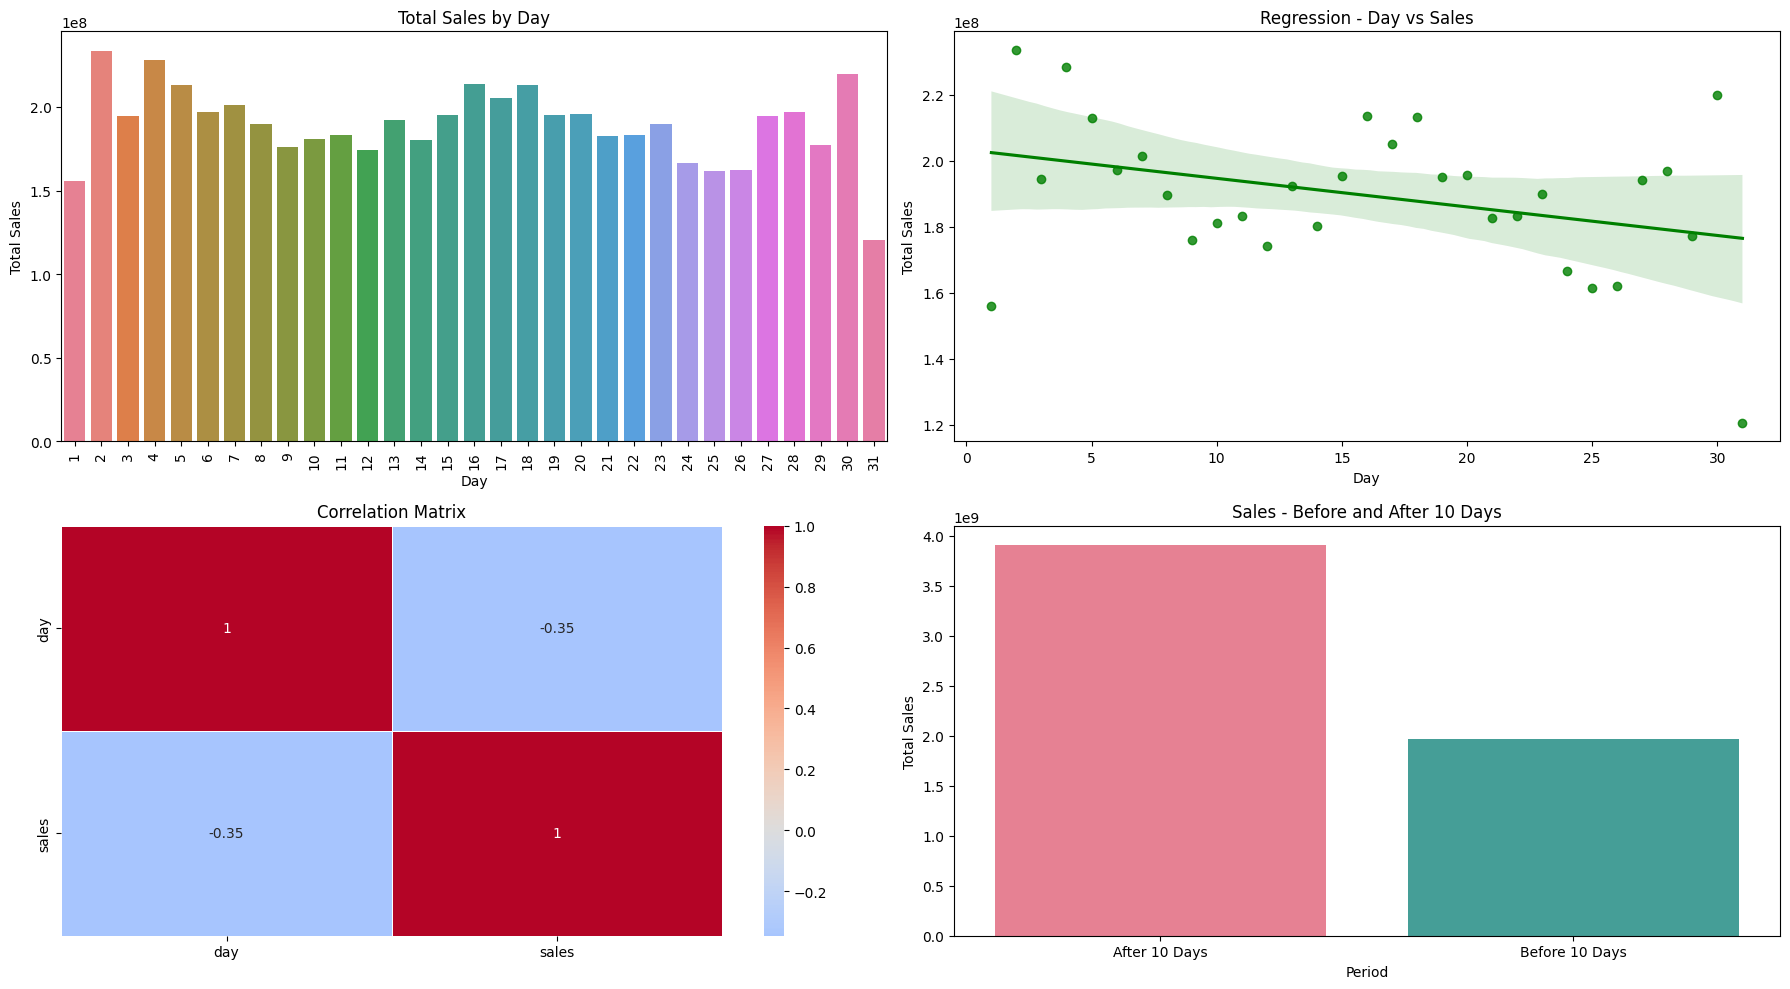

In [81]:
# Grouping the data by day and summing sales
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Defining the figure size
plt.figure(figsize=(18, 10))

# Subplot 1: Colored Bar Plot
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1, palette='husl')  # 'husl' palette for more varied colors
plt.title('Total Sales by Day')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)  # Rotate X-axis labels for better readability

# Subplot 2: Regression Plot
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1, color='green')  # Custom color for regression plot
plt.title('Regression - Day vs Sales')
plt.xlabel('Day')
plt.ylabel('Total Sales')

# Subplot 3: Correlation Heatmap
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', center=0, linewidths=0.5)  # Colored heatmap with 'coolwarm'
plt.title('Correlation Matrix')

# Subplot 4: Bar Plot (before and after 10 days)
plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'Before 10 Days' if x <= 10 else 'After 10 Days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2, palette='husl')
plt.title('Sales - Before and After 10 Days')
plt.xlabel('Period')
plt.ylabel('Total Sales')

# Adjusting layout to avoid overlap
plt.tight_layout()
plt.show()


### **H11.** Stores should sell less on weekends.
**TRUE** Stores sell less on Weekends.

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/2450139998.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='sales', data=aux1, palette='coolwarm')  # Paleta de cores 'coolwarm' para contraste


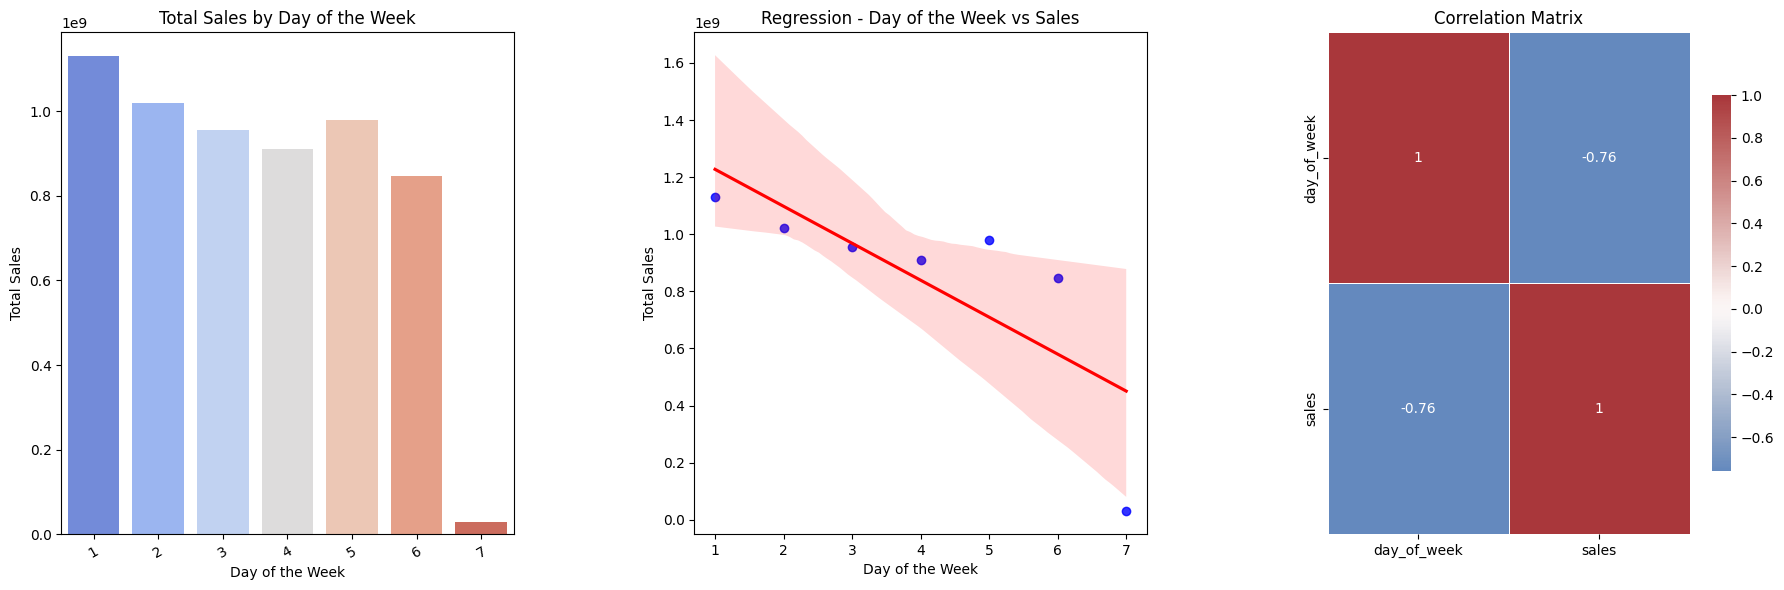

In [86]:
# Gerando os dados agrupados por dia da semana
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Definindo o tamanho da figura para acomodar melhor os gráficos
plt.figure(figsize=(18, 6))

# Subplot 1: Gráfico de Barras (Vendas por Dia da Semana)
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1, palette='coolwarm')  # Paleta de cores 'coolwarm' para contraste
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=30)  # Rotaciona os rótulos do eixo X para legibilidade

# Subplot 2: Gráfico de Regressão (Dia da Semana vs Vendas)
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})  # Personalização das cores
plt.title('Regression - Day of the Week vs Sales')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')

# Subplot 3: Heatmap de Correlação (Entre Dia da Semana e Vendas)
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='vlag', center=0, linewidths=0.5, cbar_kws={"shrink": 0.75})  # Paleta 'vlag' para um gradiente suave
plt.title('Correlation Matrix')

# Ajustando o layout para evitar sobreposição
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  # Ajuste do espaço entre os gráficos

# Exibir os gráficos
plt.show()


### **H12.** Stores should sell less during school holidays.
**TRUE** Stores sell less during school holidays, except in the months of July and a August.

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_4159/514316538.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='school_holiday', y='sales', data=aux1, palette='coolwarm')  # Using a contrasting color palette


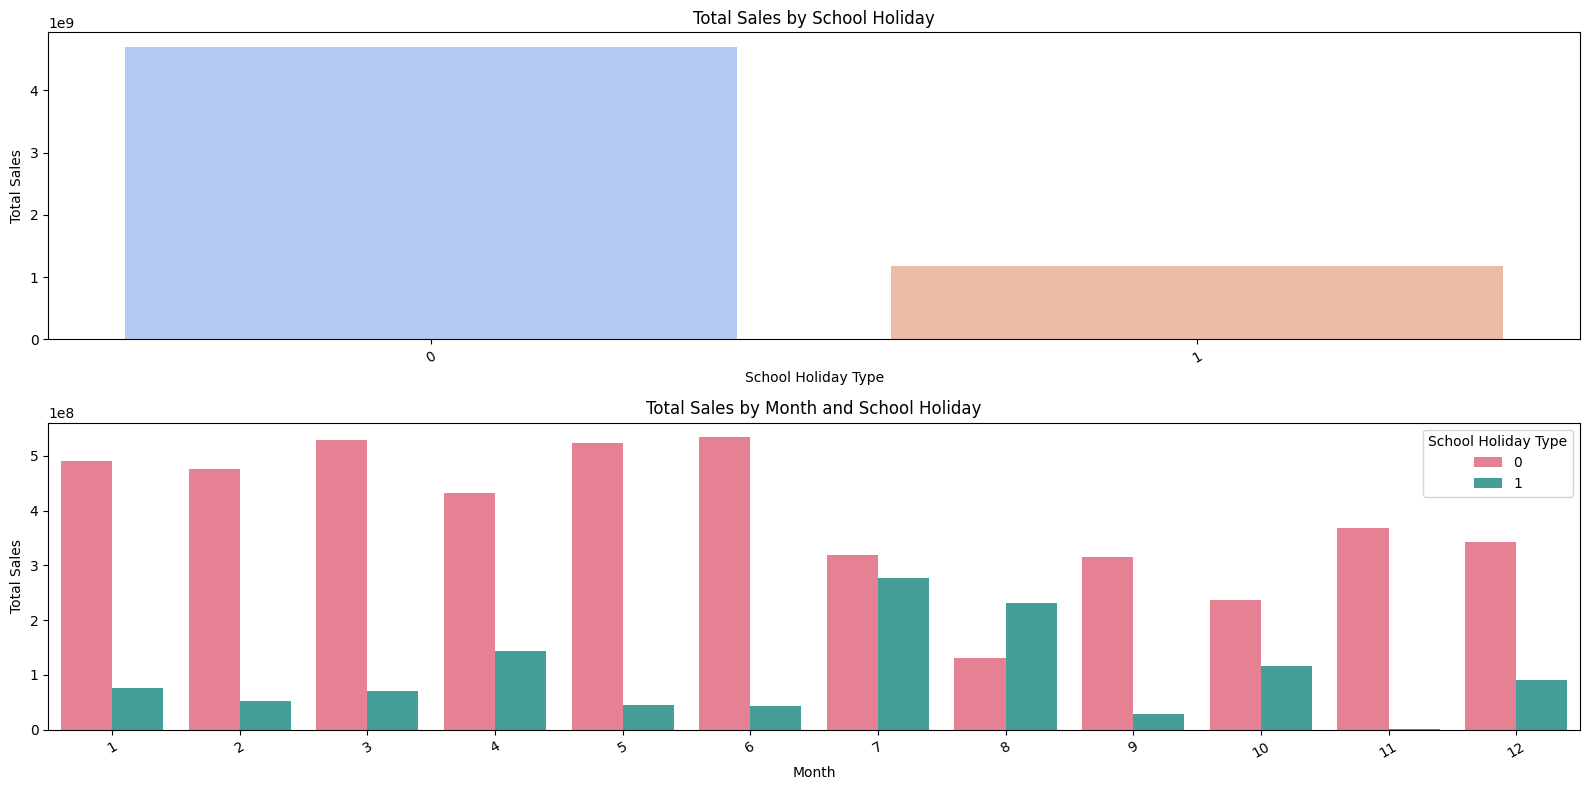

In [89]:
# Grouping the data by 'school_holiday' and summing the sales
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

# Defining the figure size for better visualization
plt.figure(figsize=(16, 8))

# Subplot 1: Bar Plot (Sales during School Holiday)
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1, palette='coolwarm')  # Using a contrasting color palette
plt.title('Total Sales by School Holiday')  # Title for the plot
plt.xlabel('School Holiday Type')  # X-axis label
plt.ylabel('Total Sales')  # Y-axis label
plt.xticks(rotation=30)  # Rotating X-axis labels for better readability

# Grouping the data by 'month' and 'school_holiday' to sum the sales
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

# Subplot 2: Bar Plot (Sales by Month and School Holiday)
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2, palette='husl')  # Using a vibrant color palette for distinction
plt.title('Total Sales by Month and School Holiday')  # Title for the plot
plt.xlabel('Month')  # X-axis label
plt.ylabel('Total Sales')  # Y-axis label
plt.legend(title='School Holiday Type')  # Legend title for clarity
plt.xticks(rotation=30)  # Rotating X-axis labels for better readability

# Adjusting the layout to avoid overlap
plt.tight_layout()
plt.show()  # Display the plots


## 4.2.1 Summary of Hypotheses

In [93]:
tab=[['Hypotheses', 'Conclusion', 'Relevance'],
     ['H1', 'False', 'Low'    ],
     ['H2', 'False', 'average'],
     ['H3', 'False', 'average'],
     ['H4', 'False', 'Low'    ],
     ['H5', '-', '-'          ],
     ['H6', 'False', 'Low'    ],
     ['H7', 'False', 'average'],
     ['H8', 'False', 'High'   ],
     ['H9', 'False', 'High'   ],
     ['H10', 'True', 'High'   ],
     ['H11', 'True', 'High'   ],
     ['H12', 'True', 'Low'    ],
    ]
print (tabulate (tab, headers='firstrow' ) )

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         average
H3            False         average
H4            False         Low
H5            -             -
H6            False         Low
H7            False         average
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

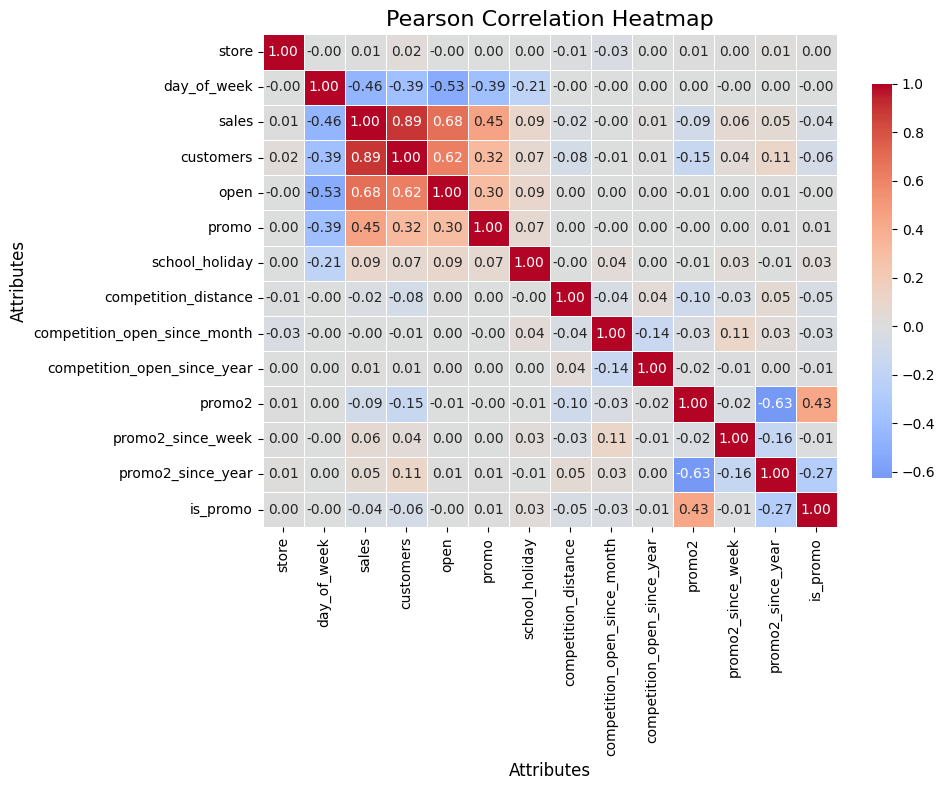

In [100]:
# Calculating the Pearson correlation matrix
correlation = num_attributes.corr(method='pearson')

# Setting the figure size for better visualization
plt.figure(figsize=(10, 8))

# Generating the heatmap with improved visuals for clarity
sns.heatmap(correlation, 
            annot=True,              # Display correlation values on the heatmap
            cmap='coolwarm',         # Color palette for better contrast
            linewidths=0.5,          # Adding gridlines between cells for readability
            cbar_kws={'shrink': 0.8}, # Adjusting the color bar size
            center=0,                # Center the color palette at zero
            fmt=".2f")               # Display the values with two decimal points

# Adding title and axis labels in English
plt.title('Pearson Correlation Heatmap', fontsize=16)
plt.xlabel('Attributes', fontsize=12)
plt.ylabel('Attributes', fontsize=12)

# Adjusting the layout to prevent label overlapping
plt.tight_layout()

# Displaying the plot
plt.show()


### 4.3.2 Categorical Attributes

In [102]:
a = df4.select_dtypes( include='object')

In [121]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).to_numpy()

In [138]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'] )
a2 = cramer_v(a['state_holiday'], a['store_type'] )
a3 = cramer_v(a['state_holiday'], a['assortment'] )

a4 = cramer_v(a['store_type'], a['state_holiday'] )
a5 = cramer_v(a['store_type'], a['store_type'] )
a6 = cramer_v(a['store_type'], a['assortment'] )

a7 = cramer_v(a['assortment'], a['state_holiday'] )
a8 = cramer_v(a['assortment'], a['store_type'] )
a9 = cramer_v(a['assortment'], a['assortment'] )

d = pd.DataFrame( { 'state_holida' : [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)


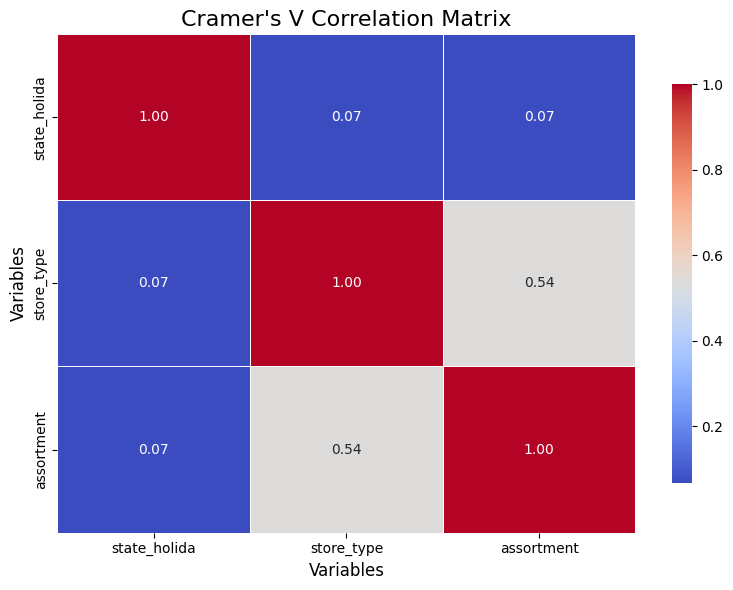

In [140]:
# Melhor visualização com heatmap
plt.figure(figsize=(8, 6))  # Define o tamanho da figura para melhor visualização
heatmap = sns.heatmap(d, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', cbar_kws={'shrink': 0.8})

# Melhorias nos rótulos
heatmap.set_title('Cramer\'s V Correlation Matrix', fontsize=16)
heatmap.set_xlabel('Variables', fontsize=12)
heatmap.set_ylabel('Variables', fontsize=12)

# Ajusta layout para evitar sobreposição
plt.tight_layout()

# Exibe o heatmap
plt.show()

# 5.0  STEP 5 - DATA PREPARATION

In [145]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

In [171]:
a = df5.select_dtypes( include=['int64','float64'])

In [175]:
rs = RobustScaler()
mms = MinMaxScaler()

# Competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# Competition Time Month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# Promo Time Week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# Year
df5['year'] = mms.fit_transform( df5[['year']].values )


## 5.3. Transformation

In [152]:
# Month
# Day
# Week of Year
# Day of Week 